In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import re
import json
import random
import time
import pickle
from brokenaxes import brokenaxes
from striprtf.striprtf import rtf_to_text
from glob import glob
from multiprocessing import Pool
from scipy.io import mmread
from collections import OrderedDict
import pandas as pd
from scipy.stats.mstats import gmean
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, zscore, ttest_ind, ranksums, spearmanr, fisher_exact
import os, sys
import statsmodels.api as sm
from copy import deepcopy
import numpy as np
from scipy.sparse import csr_matrix
from collections import Counter, defaultdict


from statannotations.Annotator import Annotator
import matplotlib.cm as cm

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"
from scipy import stats
from tqdm import tqdm
import glob

from scipy.stats import zscore
import pysam as ps
from matplotlib import gridspec,cm
from matplotlib.patches import Polygon
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def p2signif(p):
    if p<.05:
        if p<.01:
            if p<.001: return "***"
            else: return "**"
        else: return "*"
    else: return ""

### read result of each sample

In [3]:
data={}
sample=[x.split('.')[0].split('_')[1] for x in os.listdir('/home/luosongwen/scantecc/2025_03_10_Figure_result/Data/figure2') if x[:6]=="refine"]
for i in sample:
    try:
        data[i]=pd.read_table('/home/luosongwen/scantecc/2025_03_10_Figure_result/Data/figure2/refine_'+i+'.txt',index_col=0,sep=',')
        data[i].insert(3,'intersize',data[i]["end"]-data[i]["start"])
    except:
        continue

In [4]:
## read the reads information of each sample
total_reads = pd.read_table('/home/luosongwen/scantecc/2025_03_10_Figure_result/Data/total_reads.txt',header=None,index_col=0)
total_reads.index = [x.split(".")[0].split("_")[0] + x.split(".")[0].split("_")[1]for x in total_reads.index]

In [5]:
## subtract selected sample
sample_reads = total_reads.loc[sample,:]
sample_data=sample_reads.copy()

In [ ]:
## calculate epm, insert size, selected size ecpm 
sample_data.columns=["total_reads"]
sample_data["ecc_number"]=sample_data.apply(lambda x:data[x.name][data[x.name]["count"]>=1].shape[0],axis=1)
sample_data["epm"]=sample_data["ecc_number"]/sample_data["total_reads"] * 1000000
sample_data["intersize"]=sample_data.apply(lambda x:abs(data[x.name]["end"]-data[x.name]["start"]).values,axis=1)
sample_data["ec_count"]=sample_data.apply(lambda x:len([y for y in x["intersize"] if (y >= 1000) & (y <= 1000000)]),axis=1)
sample_data["ecpm"]=sample_data["ec_count"]/sample_data["total_reads"] * 1000000

sample_data["group"]=["Mouse"  if x[:5] == "mouse" else "Human" for x in sample_data.index]
sample_data["name"]=[x.split("HG")[1][:4] for x in sample_data.index]
sample_data["ratio"]=sample_data["ec_count"]/sample_data["ecc_number"]

In [7]:
sample_data.head()

,total_reads,ecc_number,epm,intersize,ec_count,ecpm,group,name,ratio
R22041543-T266-HG1471combined,68620005,237,3.453803,"[626, 1385, 378, 1101, 356, 1143, 811, 640, 22...",108,1.573885,Human,1471,0.455696
R22041543-T266-HG1470combined,61683816,178,2.885684,"[343996, 2004, 3364, 706, 1029, 3148, 4599, 37...",91,1.475265,Human,1470,0.511236
R22051616-T279-HG1534combined,40614854,87,2.142073,"[753, 1975, 151, 195, 200, 1452, 200, 18, 206,...",15,0.369323,Human,1534,0.172414
mouseR22041543-T266-HG1470,120645751,395,3.274048,"[366, 204, 177, 209, 184, 178, 176, 325, 188, ...",3,0.024866,Mouse,1470,0.007595
R22051616-T279-HG1535combined,37356842,251,6.718983,"[18, 169, 799783, 475, 911, 2108, 200, 1359, 2...",79,2.114740,Human,1535,0.314741


### eccDNA_length_ratio

In [9]:
### new_length_bin 划分
temp = sample_data.copy()
bins=[0,100,500,1000,5000,10000,50000,100000,1000000]
count=temp.apply(lambda x:pd.value_counts(pd.cut(x["intersize"],bins)),axis=1)
ratio=(count.T/count.sum(axis=1)).T
mouse=ratio[ratio.index.str.contains('mouse')].mean()
human=ratio[~ratio.index.str.contains('mouse')].mean()
ratio["group"]=["Mouse"  if x[:5] == "mouse" else "Human" for x in sample_data.index]
merge=pd.concat([mouse,human],axis=1)
merge.columns=["mouse","human"]

In [10]:
temp = sample_data.copy()
bins=[0,200,500,1000,2000,5000,10000,50000,100000]
count=temp.apply(lambda x:pd.value_counts(pd.cut(x["intersize"],bins)),axis=1)
ratio=(count.T/count.sum(axis=1)).T
mouse=ratio[ratio.index.str.contains('mouse')].mean()
human=ratio[~ratio.index.str.contains('mouse')].mean()
ratio["group"]=["Mouse"  if x[:5] == "mouse" else "Human" for x in sample_data.index]
merge=pd.concat([mouse,human],axis=1)
merge.columns=["mouse","human"]

([<matplotlib.axis.YTick at 0x7f864d6412e0>,
 [Text(0, 0.5, '0-0.2 kb'),
  Text(0, 1.5, '0.2-0.5 kb'),
  Text(0, 2.5, '0.5-1 kb'),
  Text(0, 3.5, '1-2 kb'),
  Text(0, 4.5, '2-5 kb'),
  Text(0, 5.5, '5-10 kb'),
  Text(0, 6.5, '10-50 kb'),
  Text(0, 7.5, '50-100 kb')])

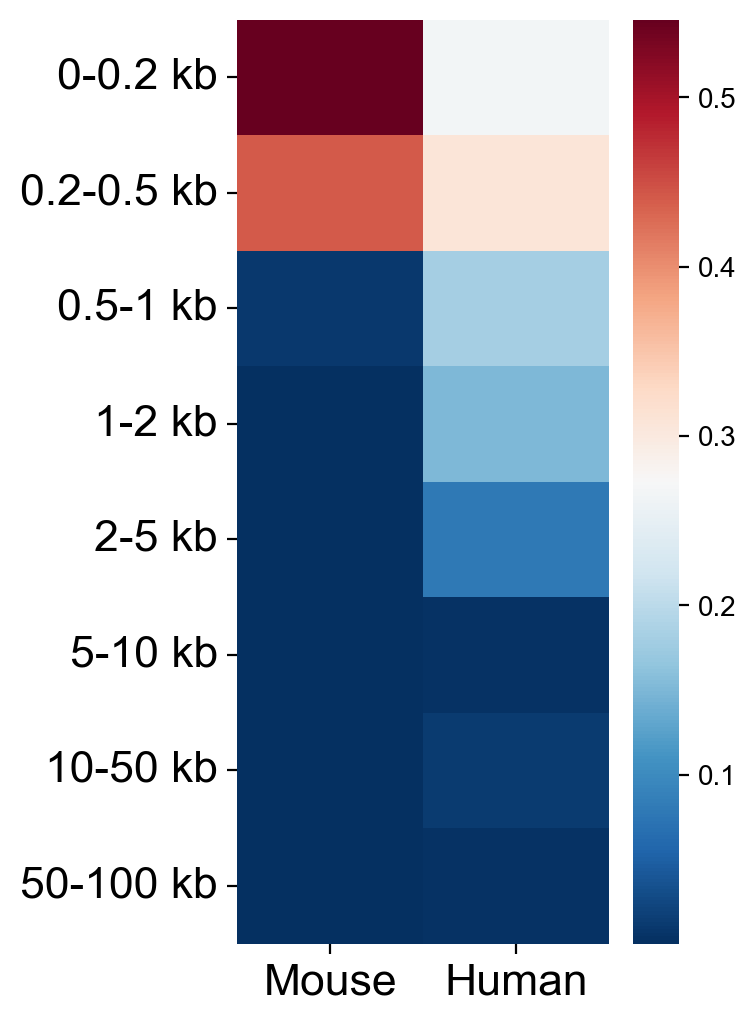

In [11]:
plt.figure(figsize = (3,6))
sns.heatmap(merge,cmap="RdBu_r")
plt.xticks([.5,1.5],['Mouse','Human'], fontsize=16)
plt.yticks([.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5],['0-0.2 kb','0.2-0.5 kb', '0.5-1 kb', '1-2 kb', '2-5 kb', '5-10 kb', '10-50 kb', '50-100 kb'], fontsize=16)

In [12]:
temp = sample_data.copy()
bins=[0,100,500,1000,5000,10000,50000,100000,1000000]
count=temp.apply(lambda x:pd.value_counts(pd.cut(x["intersize"],bins)),axis=1)
ratio=(count.T/count.sum(axis=1)).T
mouse=ratio[ratio.index.str.contains('mouse')].mean()
human=ratio[~ratio.index.str.contains('mouse')].mean()
ratio["group"]=["Mouse"  if x[:5] == "mouse" else "Human" for x in sample_data.index]
merge=pd.concat([mouse,human],axis=1)
merge.columns=["mouse","human"]

([<matplotlib.axis.YTick at 0x7f864cf1a490>,
 [Text(0, 0.5, '0-0.1 kb'),
  Text(0, 1.5, '0.1-0.5 kb'),
  Text(0, 2.5, '0.5-1 kb'),
  Text(0, 3.5, '1-5 kb'),
  Text(0, 4.5, '5-10 kb'),
  Text(0, 5.5, '10-50 kb'),
  Text(0, 6.5, '50-100 kb'),
  Text(0, 7.5, '> 100 kb')])

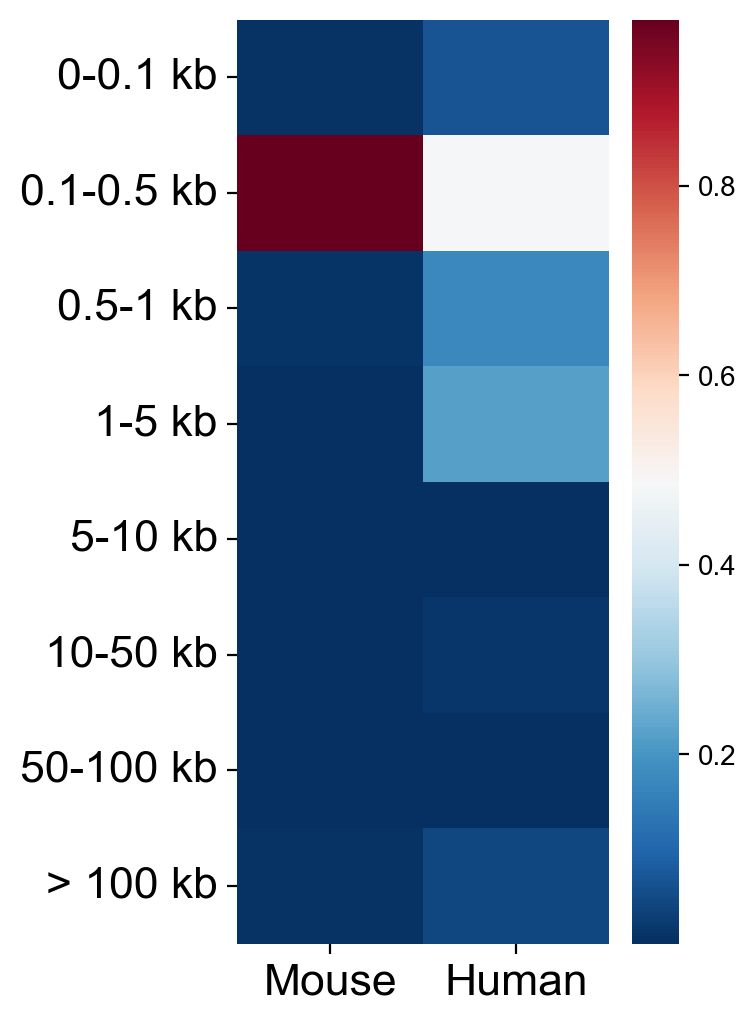

In [13]:
plt.figure(figsize = (3,6))
sns.heatmap(merge,cmap="RdBu_r")
plt.xticks([.5,1.5],['Mouse','Human'], fontsize=16)
plt.yticks([.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5],['0-0.1 kb','0.1-0.5 kb', '0.5-1 kb', '1-5 kb', '5-10 kb', '10-50 kb', '50-100 kb', '> 100 kb'], fontsize=16)
#plt.savefig('../figures/fig2_ratio.pdf',bbox_inches='tight')

In [ ]:
#plt.savefig('/home/luosongwen/scantecc/2025_03_10_Figure_result/Figure/Sfig3A_heatmap/sfig3A_mousecluster_map_vmax_1.0.pdf',bbox_inches='tight')

### Figure 1f Proportion of long eccDNA (>1000 bp) among tumor-derived and non-tumor-derived cell-free eccDNA identified from PDX mouse plasma

In [15]:
temp = sample_data.copy()
palette_group = {'Human': '#F36161', 'Mouse': '#2982FB'}

/tmp/ipykernel_53235/3311718486.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="group", y="ratio", data=temp, linewidth=2.5,
/tmp/ipykernel_53235/3311718486.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="group", y="ratio", data=temp, edgecolor='black',


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mouse vs. Human: t-test independent samples, P_val:3.845e-03 t=-3.740e+00


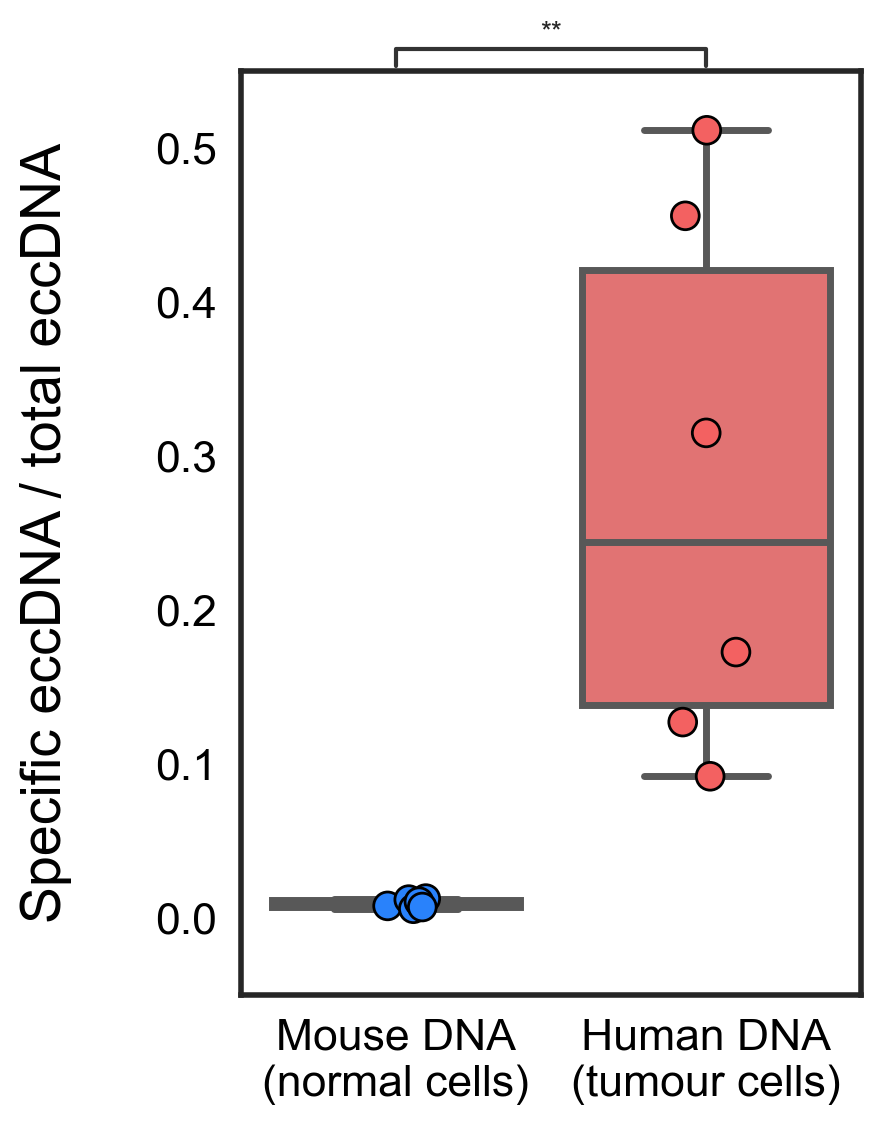

In [17]:
# 设置 Seaborn 风格
sns.set_style('white')

# 创建画布
fig, ax = plt.subplots(figsize=(4, 6))

# 绘制箱线图
sns.boxplot(x="group", y="ratio", data=temp, linewidth=2.5, 
            palette=palette_group, order=['Mouse', 'Human'], ax=ax)

# 绘制散点图
sns.stripplot(x="group", y="ratio", data=temp, edgecolor='black',
              linewidth=1, palette=palette_group, size=10, order=['Mouse', 'Human'], ax=ax)

# 设定显著性检验的比较组
box_pairs = [("Mouse", "Human")]

# 添加显著性标记
annot = Annotator(ax, box_pairs, data=temp, x="group", y="ratio", order=['Mouse', 'Human'])
annot.configure(test='t-test_ind', text_format='star', loc='outside')  # 使标记放在框外以防止重叠
annot.apply_and_annotate()

# 调整边框线条宽度
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

# **设置 X 轴刻度**
ax.set_xticks([0, 1])
ax.set_xticklabels(['Mouse DNA\n(normal cells)', 'Human DNA\n(tumour cells)'], 
                   fontsize=16, color='black')

# **设置 Y 轴刻度**
yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
ax.set_yticks(yticks)  
ax.set_yticklabels([f"{tick:.1f}" for tick in yticks], fontsize=16, color='black')

# **确保 Y 轴刻度可见**
ax.set_ylim([-0.05, 0.55])  # 手动扩大 y 轴范围，确保刻度不会被隐藏
ax.yaxis.set_visible(True)  # 确保 y 轴刻度可见
ax.yaxis.set_major_locator(plt.FixedLocator(yticks))  # 强制刻度可见

# **设置刻度线可见**
ax.tick_params(axis='both', direction='out', length=5, width=1)

# **设置 Y 轴标签**
ax.set_xlabel('')
ax.set_ylabel("Specific eccDNA / total eccDNA", fontsize=20, labelpad=30, color='black')

### 保存图片
#plt.savefig('/home/luosongwen/scantecc/2025_03_10_Figure_result/Figure/Figure2C/Figure2C_refined.pdf',bbox_inches='tight')

# **显示图像**
plt.show()

### Figure 1g Genomic feature enrichment of tumor-derived and non-tumor-derived cell-free eccDNA identified from PDX mouse plasma

In [19]:
###修改后的分bin长度
###新代码纵向计算，计算的是每个元件，不同区间cover的数目/所有区间cover该元件总数。即不同长度区间覆盖该元件的数量 / 所有长度区间覆盖该元件的总数
# 定义长度区间 (lenbin) 和基因组区域 (region_list) 这里取得bedtools intersect -F 0.5
lenbin_list = ['0_200', '200_500', '500_1000', '1000_2000', '2000_5000', '5000_10000']
region_list = ['exon', 'transcript', 'gene', '3UTR', '5UTR', 'Intergenic', 'SINE', 'LINE', 'LTR', 'Simple_repeat', 'Low_complexity', 'Satellite']

# 初始化用于存储最终比例的 DataFrame
human_elements_plot = pd.DataFrame(index=lenbin_list, columns=region_list).fillna(0)
mouse_elements_plot = pd.DataFrame(index=lenbin_list, columns=region_list).fillna(0)

# 计算每个基因组区域的总覆盖数（用于归一化）
human_total_counts = {region: 0 for region in region_list}
mouse_total_counts = {region: 0 for region in region_list}

# 遍历所有长度区间
for lenbin in lenbin_list:
    # 读取小鼠和人类的 eccDNA 片段数目
    mouse_ecDNA = len(pd.read_csv(f'/home/luosongwen/scantecc/2025_03_10_Figure_result/Data/tmp_files/fig2/refined_frag/mouse_{lenbin}.bed', header=None, sep='\t'))
    human_ecDNA = len(pd.read_csv(f'/home/luosongwen/scantecc/2025_03_10_Figure_result/Data/tmp_files/fig2/refined_frag/human_{lenbin}.bed', header=None, sep='\t'))

    # 读取基因区域的注释信息，并统计覆盖某个区域的 eccDNA 数量
    if os.path.getsize(f'/home/luosongwen/scantecc/2025_03_10_Figure_result/Data/tmp_files/fig2/refined_F05_intersect/mouse_{lenbin}.gene.bed'):
        mouse_gene = pd.read_csv(f'/home/luosongwen/scantecc/2025_03_10_Figure_result/Data/tmp_files/fig2/refined_F05_intersect/mouse_{lenbin}.gene.bed', header=None, sep='\t')
        for region in ['exon', 'transcript', 'gene', '3UTR', '5UTR']:
            count = len(mouse_gene[mouse_gene[7] == region][3].unique())
            mouse_elements_plot.loc[lenbin, region] = count
            mouse_total_counts[region] += count  # 累积总数
        mouse_elements_plot.loc[lenbin, 'Intergenic'] = len(mouse_gene[3].unique())
        mouse_total_counts['Intergenic'] += len(mouse_gene[3].unique())

    if os.path.getsize(f'/home/luosongwen/scantecc/2025_03_10_Figure_result/Data/tmp_files/fig2/refined_F05_intersect/human_{lenbin}.gene.bed'):
        human_gene = pd.read_csv(f'/home/luosongwen/scantecc/2025_03_10_Figure_result/Data/tmp_files/fig2/refined_F05_intersect/human_{lenbin}.gene.bed', header=None, sep='\t')
        for region in ['exon', 'transcript', 'gene', '3UTR', '5UTR']:
            count = len(human_gene[human_gene[7] == region][3].unique())
            human_elements_plot.loc[lenbin, region] = count
            human_total_counts[region] += count
        human_elements_plot.loc[lenbin, 'Intergenic'] = len(human_gene[3].unique())
        human_total_counts['Intergenic'] += len(human_gene[3].unique())

    # 读取重复序列区域的注释信息，并统计覆盖某个区域的 eccDNA 数量
    if os.path.getsize(f'/home/luosongwen/scantecc/2025_03_10_Figure_result/Data/tmp_files/fig2/refined_F05_intersect/mouse_{lenbin}.simple.bed'):
        mouse_simple = pd.read_csv(f'/home/luosongwen/scantecc/2025_03_10_Figure_result/Data/tmp_files/fig2/refined_F05_intersect/mouse_{lenbin}.simple.bed', header=None, sep='\t')
        for region in ['SINE', 'LINE', 'LTR', 'Simple_repeat', 'Low_complexity', 'Satellite']:
            count = len(mouse_simple[mouse_simple[7] == region][3].unique())
            mouse_elements_plot.loc[lenbin, region] = count
            mouse_total_counts[region] += count

    if os.path.getsize(f'/home/luosongwen/scantecc/2025_03_10_Figure_result/Data/tmp_files/fig2/refined_F05_intersect/human_{lenbin}.simple.bed'):
        human_simple = pd.read_csv(f'/home/luosongwen/scantecc/2025_03_10_Figure_result/Data/tmp_files/fig2/refined_F05_intersect/human_{lenbin}.simple.bed', header=None, sep='\t')
        for region in ['SINE', 'LINE', 'LTR', 'Simple_repeat', 'Low_complexity', 'Satellite']:
            count = len(human_simple[human_simple[7] == region][3].unique())
            human_elements_plot.loc[lenbin, region] = count
            human_total_counts[region] += count

# **归一化计算：将每个长度区间的数值除以对应基因组区域的总数**
for region in region_list:
    if human_total_counts[region] > 0:
        human_elements_plot[region] = human_elements_plot[region] / human_total_counts[region]
    if mouse_total_counts[region] > 0:
        mouse_elements_plot[region] = mouse_elements_plot[region] / mouse_total_counts[region]

# **填充 NaN 为 0，防止后续绘图出错**
human_elements_plot.fillna(0, inplace=True)
mouse_elements_plot.fillna(0, inplace=True)

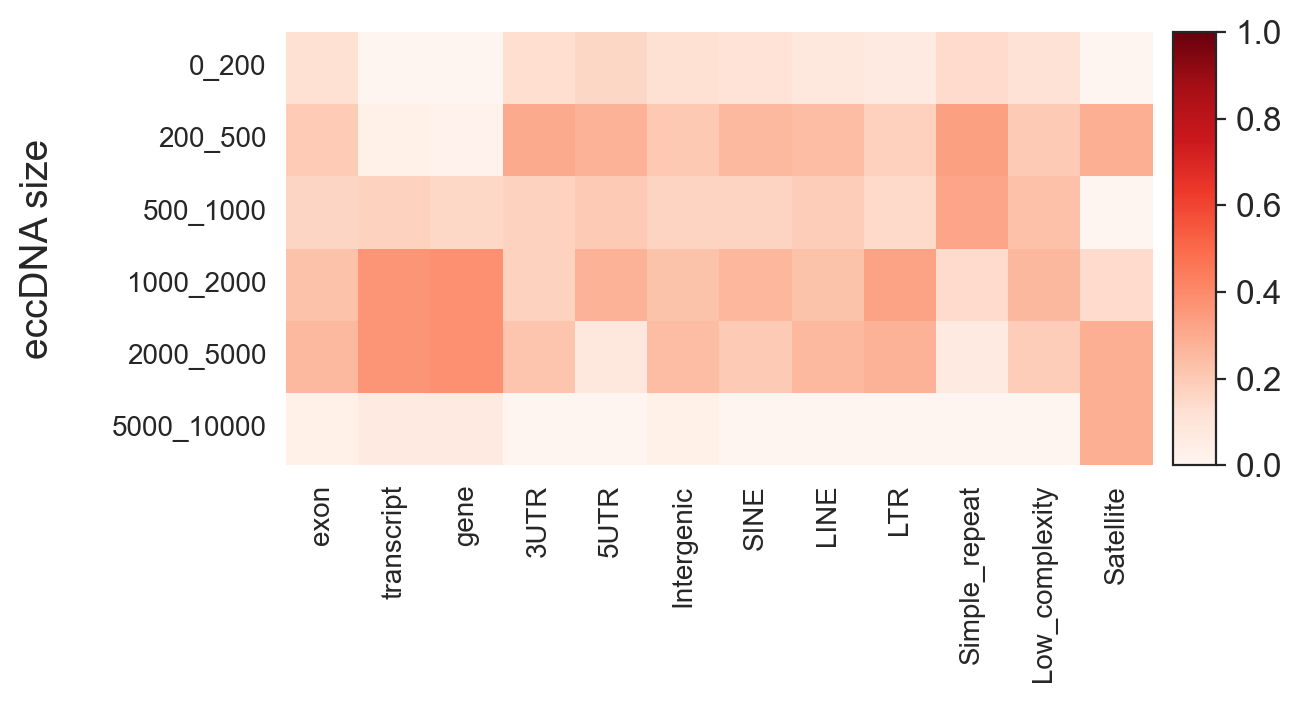

In [22]:
plt.figure(figsize=(6, 6))

# 创建主热图
ax = sns.heatmap(data=human_elements_plot, 
                 cmap=sns.color_palette("Reds", as_cmap=True), 
                 square=True, 
                 vmin=0.0, 
                 vmax=1.0, 
                 cbar=False)  # 先禁用默认 colorbar

# 获取热图的位置并调整
pos = ax.get_position()
ax.set_position([pos.x0 + 0.2, pos.y0, pos.width, pos.height])

# 添加直角三角形
#triangle_ax = plt.gca().inset_axes([-0.37, 0, 0.15, 1], transform=ax.transAxes)
#triangle = Polygon([[0, 0], [1, 0], [1, 1]], closed=True, facecolor="black")  # 直角三角形
#triangle_ax.add_patch(triangle)
#triangle_ax.set_xlim(0, 1)
#triangle_ax.set_ylim(0, 1)
#triangle_ax.axis("off")  # 关闭坐标轴

# 添加 colorbar 并匹配热图高度
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)  # 创建新的 colorbar 轴
cbar = plt.colorbar(ax.collections[0], cax=cax)  # 绑定 colorbar
cbar.ax.tick_params(labelsize=12)  # 设置 colorbar 刻度大小
#cbar.set_label("Density", fontsize=14)  # 设置 colorbar 标签

# 添加 y 轴标签
ax.set_ylabel("eccDNA size", fontsize=14, labelpad=20)

# 旋转 x 轴标签
plt.xticks(rotation=30, ha='right')
#plt.savefig('/home/luosongwen/scantecc/2025_03_10_Figure_result/Figure/Sfig3A_heatmap/sfig3A_humancluster_map_vmax_1.0.pdf',bbox_inches='tight')
plt.show()

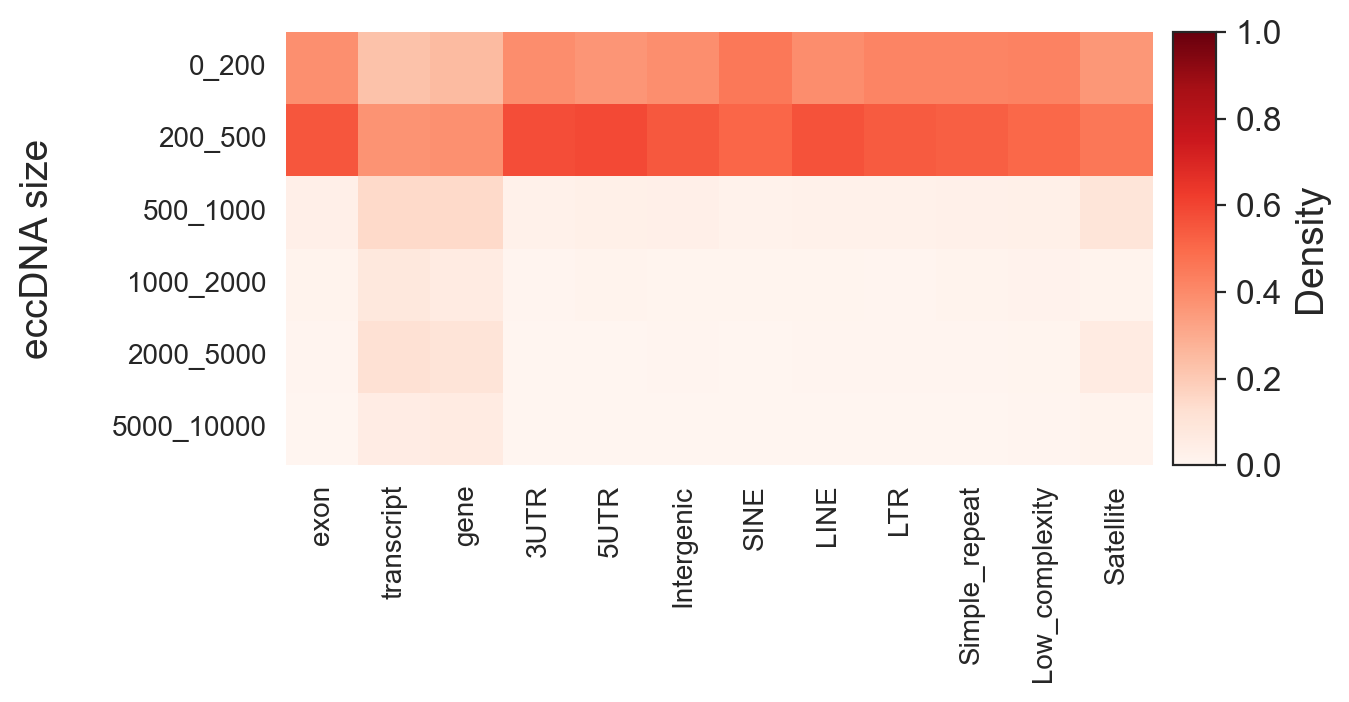

In [24]:
plt.figure(figsize=(6, 6))

# 创建主热图
ax = sns.heatmap(data=mouse_elements_plot, 
                 cmap=sns.color_palette("Reds", as_cmap=True), 
                 square=True, 
                 vmin=0.0, 
                 vmax=1.0, 
                 cbar=False)  # 先禁用默认 colorbar

# 获取热图的位置并调整
pos = ax.get_position()
ax.set_position([pos.x0 + 0.2, pos.y0, pos.width, pos.height])

# 添加直角三角形
#triangle_ax = plt.gca().inset_axes([-0.37, 0, 0.15, 1], transform=ax.transAxes)
#triangle = Polygon([[0, 0], [1, 0], [1, 1]], closed=True, facecolor="black")  # 直角三角形
#triangle_ax.add_patch(triangle)
#triangle_ax.set_xlim(0, 1)
#triangle_ax.set_ylim(0, 1)
#triangle_ax.axis("off")  # 关闭坐标轴

# 添加 colorbar 并匹配热图高度
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)  # 创建新的 colorbar 轴
cbar = plt.colorbar(ax.collections[0], cax=cax)  # 绑定 colorbar
cbar.ax.tick_params(labelsize=12)  # 设置 colorbar 刻度大小
cbar.set_label("Density", fontsize=14)  # 设置 colorbar 标签

# 添加 y 轴标签
ax.set_ylabel("eccDNA size", fontsize=14, labelpad=20)

# 旋转 x 轴标签
plt.xticks(rotation=30, ha='right')
#plt.savefig('/home/luosongwen/scantecc/2025_03_10_Figure_result/Figure/Sfig3A_heatmap/sfig3A_mousecluster_map_vmax_1.0.pdf',bbox_inches='tight')
plt.show()

In [25]:
difference_elements_plot = human_elements_plot - mouse_elements_plot

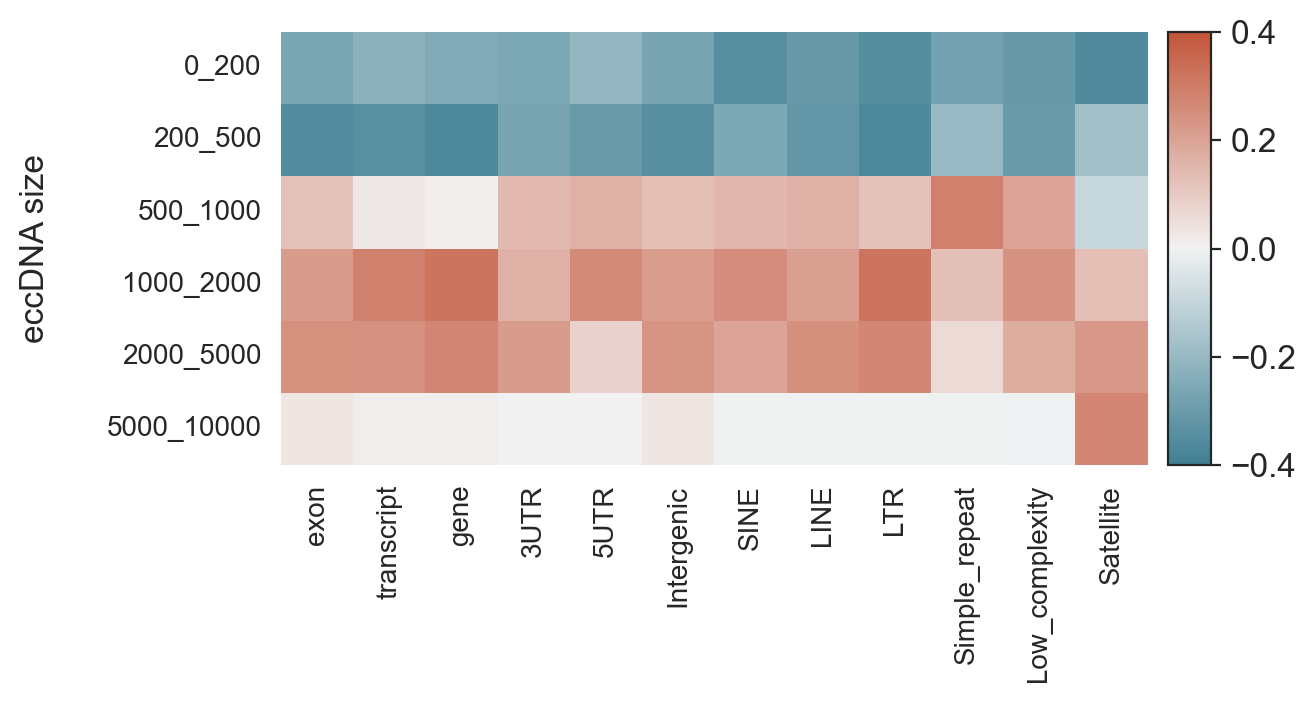

In [27]:
plt.figure(figsize=(6, 6))

# 创建主热图
ax = sns.heatmap(data=difference_elements_plot, 
                 #cmap=sns.color_palette("coolwarm", as_cmap=True), 
                 cmap=sns.diverging_palette(220, 20, as_cmap=True),
                 square=True, 
                 vmin=-0.4, 
                 vmax=0.4, 
                 cbar=False)  # 先禁用默认 colorbar

# 获取热图的位置并调整
pos = ax.get_position()
ax.set_position([pos.x0 + 0.2, pos.y0, pos.width, pos.height])

# 添加直角三角形
#triangle_ax = plt.gca().inset_axes([-0.37, 0, 0.15, 1], transform=ax.transAxes)
#triangle = Polygon([[0, 0], [1, 0], [1, 1]], closed=True, facecolor="black")  # 直角三角形
#triangle_ax.add_patch(triangle)
#triangle_ax.set_xlim(0, 1)
#triangle_ax.set_ylim(0, 1)
#triangle_ax.axis("off")  # 关闭坐标轴

# 添加 colorbar 并匹配热图高度
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)  # 创建新的 colorbar 轴
cbar = plt.colorbar(ax.collections[0], cax=cax)  # 绑定 colorbar
cbar.ax.tick_params(labelsize=12)  # 设置 colorbar 刻度大小
#cbar.set_label("Density", fontsize=14)  # 设置 colorbar 标签

# 添加 y 轴标签
ax.set_ylabel("eccDNA size", fontsize=12, labelpad=20)

# 旋转 x 轴标签
plt.xticks(rotation=30, ha='right')
#plt.savefig('/home/luosongwen/scantecc/2025_03_10_Figure_result/Figure/Sfig3A_heatmap/Figure2D_diffcluster_map.pdf',bbox_inches='tight')
plt.show()

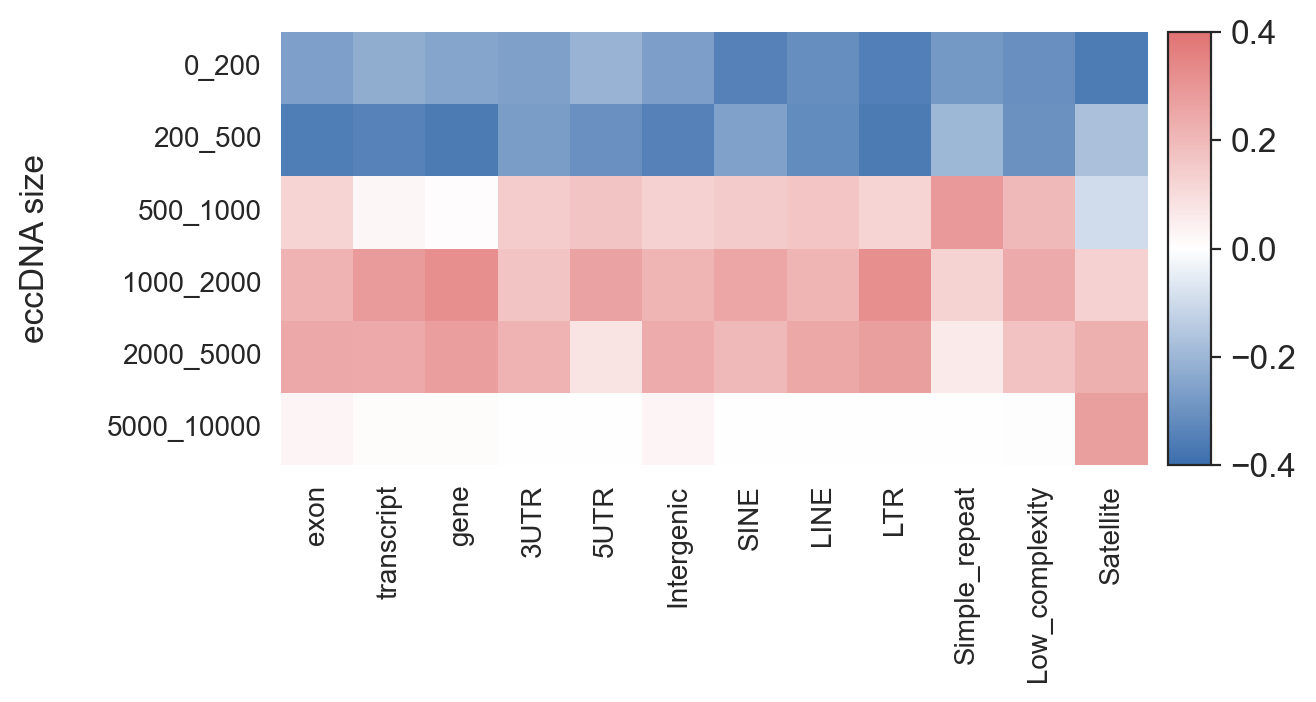

In [28]:
# 创建从红 → 白 → 蓝的 colormap
# hex_colors = ['#e17373', '#ffffff', '#3b6ead']
hex_colors = ['#3b6ead', '#ffffff', '#e17373']
custom_cmap = LinearSegmentedColormap.from_list("custom_redwhiteblue", hex_colors)

# 绘图部分（保持你的配置不变）
plt.figure(figsize=(6, 6))

ax = sns.heatmap(data=difference_elements_plot, 
                 cmap=custom_cmap,        # 使用自定义cmap
                 square=True, 
                 vmin=-0.4, vmax=0.4, 
                 cbar=False)

# 调整位置
pos = ax.get_position()
ax.set_position([pos.x0 + 0.2, pos.y0, pos.width, pos.height])

# 添加 colorbar（单独设置）
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(ax.collections[0], cax=cax)
cbar.ax.tick_params(labelsize=12)

# 添加标签和细节
ax.set_ylabel("eccDNA size", fontsize=12, labelpad=20)
plt.xticks(rotation=30, ha='right')
#plt.savefig('/home/luosongwen/scantecc/2025_03_10_Figure_result/Figure/Sfig3A_heatmap/Figure2D_diffcluster_map.pdf',bbox_inches='tight')
# 显示图像
plt.show()

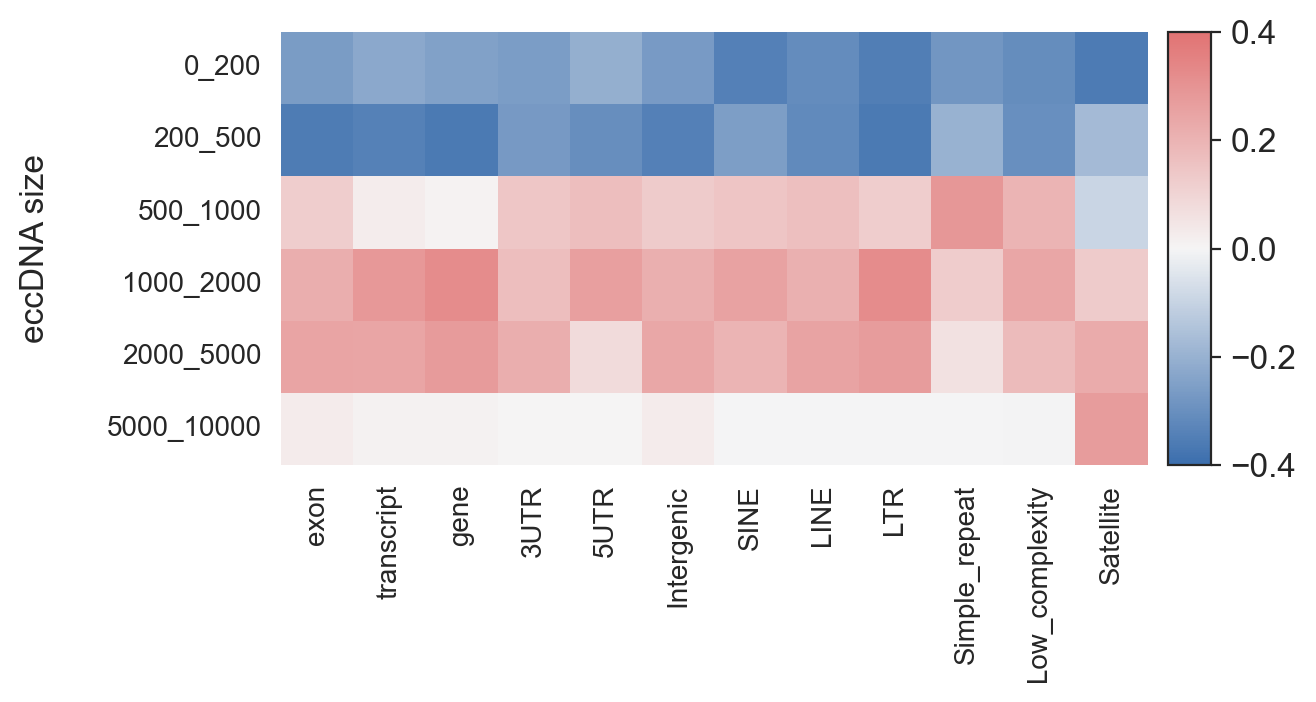

In [29]:
# 设置自定义渐变颜色：蓝 → 浅灰色 → 红
hex_colors = ['#3b6ead', '#f5f5f5', '#e17373']
custom_cmap = LinearSegmentedColormap.from_list("custom_redgrayblue", hex_colors)

# 创建图像
plt.figure(figsize=(6, 6))

ax = sns.heatmap(
    data=difference_elements_plot, 
    cmap=custom_cmap,      # 使用自定义色图
    square=True, 
    vmin=-0.4, vmax=0.4, 
    cbar=False
)

# 保证显示所有刻度（特别是当数据较小时 Seaborn 可能自动隐藏部分刻度）
# ax.set_xticks(range(difference_elements_plot.shape[1]))
# ax.set_xticklabels(difference_elements_plot.columns, rotation=30, ha='right', fontsize=10)

# ax.set_yticks(range(difference_elements_plot.shape[0]))
# ax.set_yticklabels(difference_elements_plot.index, fontsize=10)

# 调整热图位置（靠右一些）
pos = ax.get_position()
ax.set_position([pos.x0 + 0.2, pos.y0, pos.width, pos.height])

# 添加 colorbar（绑定到热图）
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(ax.collections[0], cax=cax)
cbar.ax.tick_params(labelsize=12)

# 设置 y 轴标签
ax.set_ylabel("eccDNA size", fontsize=12, labelpad=20)

#plt.savefig('/home/luosongwen/scantecc/2025_03_10_Figure_result/candidate_figure/Figure1G_diffcluster_map.pdf',bbox_inches='tight')
# 显示图像
plt.show()